# Softmax 

* **Purpose:** The softmax function generalizes logistic regression to the **multi-class** case (more than two categories).

* **Class scores (logits):** For each class (i), a score (logit) is computed as
  $
  z_i = w_i^\top x + b_i
  $
  In 1D, these correspond to different lines; in higher dimensions, they are **dot products** between the input vector (x) and the parameter vectors (w_i).

* **Decision (hard prediction):** The predicted class is the index with the highest score:
  
  $\hat{y} = \arg\max_i z_i$
  
  (In the examples: blue/red/green regions in 1D, or in 2D, points assigned to the parameter vector (w_i) producing the largest dot product.)

* **Probabilities (soft prediction):** The logits are transformed into probabilities using the softmax function:
  
  $p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$
  
  Each class gets a probability between 0 and 1, and all probabilities sum to 1.

* **Geometric intuition (2D / MNIST example):**

  * Each **class** is represented by a parameter vector (w_i).
  * Each sample (x) is classified according to the (w_i) with the highest dot product (the “closest” vector).
  * The MNIST example shows how 28×28 grayscale images (784 pixels) are flattened into vectors for classification; for visualization, the idea is simplified to 2D.

* **Training:** In practice, softmax is trained using **cross-entropy loss**, which encourages the correct class to have the highest logit.

* **Summary:**

  1. Compute logits (z_i) for each class.
  2. Use **argmax** to pick the predicted class.
  3. Use **softmax** to convert logits into class probabilities.
  4. Train the model with **cross-entropy loss** for multi-class classification.

  ---


## Softmax Regression

### **Purpose and Context**
- Used for **multiclass classification** problems (more than two classes)
- Alternative to logistic regression, which is limited to binary classification

### **Model Architecture**
- Structure similar to **multi-output linear regression**
- Given the input **x**, the model produces a **logit(z)** vector with one value for each class
- No final activation function (works directly on the logits)

### **Class Prediction**
- Prediction is obtained by finding the **maximum value** index in the logits
- **argmax** operation along the class axis (`max(dim=1)` in PyTorch)
- For each sample in the batch, the class with the highest logit is selected

### **PyTorch Implementation**
```python
class SoftmaxRegression(nn.Module):
def __init__(self, input_size, outsize): # outsize = number of classes
super().__init__()
self.linear = nn.Linear(input_size, outsize)

def forward(self, x):
z = self.linear(x) # Output: logits, not probabilities
return z
```

### **Practical Example**
- 2D input, 3 classes → model returns vector **z** of dimension 3
- `z.max(dim=1)` identifies the index of the predicted class for each row
- Example: maximum indices [1, 1, 2] → predicted classes **ŷ** = [1, 1, 2]

### **Batch Management**
- The model processes **multiple samples simultaneously**
- Each row of the output matrix **z** corresponds to a different sample
- The operation argmax is applied **independently for each row**

---

In [3]:
# Import the libraries we need for this lab

import torch.nn as nn
import torch
import matplotlib.pyplot as plt 
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [4]:
# Create class for plotting

def plot_data(data_set, model = None, n = 1, color = False):
    X = data_set[:][0]
    Y = data_set[:][1]
    plt.plot(X[Y == 0, 0].numpy(), Y[Y == 0].numpy(), 'bo', label = 'y = 0')
    plt.plot(X[Y == 1, 0].numpy(), 0 * Y[Y == 1].numpy(), 'ro', label = 'y = 1')
    plt.plot(X[Y == 2, 0].numpy(), 0 * Y[Y == 2].numpy(), 'go', label = 'y = 2')
    plt.ylim((-0.1, 3))
    plt.legend()
    if model != None:
        w = list(model.parameters())[0][0].detach()
        b = list(model.parameters())[1][0].detach()
        y_label = ['yhat=0', 'yhat=1', 'yhat=2']
        y_color = ['b', 'r', 'g']
        Y = []
        for w, b, y_l, y_c in zip(model.state_dict()['0.weight'], model.state_dict()['0.bias'], y_label, y_color):
            Y.append((w * X + b).numpy())
            plt.plot(X.numpy(), (w * X + b).numpy(), y_c, label = y_l)
        if color == True:
            x = X.numpy()
            x = x.reshape(-1)
            top = np.ones(x.shape)
            y0 = Y[0].reshape(-1)
            y1 = Y[1].reshape(-1)
            y2 = Y[2].reshape(-1)
            plt.fill_between(x, y0, where = y1 > y1, interpolate = True, color = 'blue')
            plt.fill_between(x, y0, where = y1 > y2, interpolate = True, color = 'blue')
            plt.fill_between(x, y1, where = y1 > y0, interpolate = True, color = 'red')
            plt.fill_between(x, y1, where = ((y1 > y2) * (y1 > y0)),interpolate = True, color = 'red')
            plt.fill_between(x, y2, where = (y2 > y0) * (y0 > 0),interpolate = True, color = 'green')
            plt.fill_between(x, y2, where = (y2 > y1), interpolate = True, color = 'green')
    plt.legend()
    plt.show()

In [5]:
#Set the random seed

torch.manual_seed(0)

In [6]:
# Create the data class

class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-2, 2, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0])
        self.y[(self.x > -1.0)[:, 0] * (self.x < 1.0)[:, 0]] = 1
        self.y[(self.x >= 1.0)[:, 0]] = 2
        self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

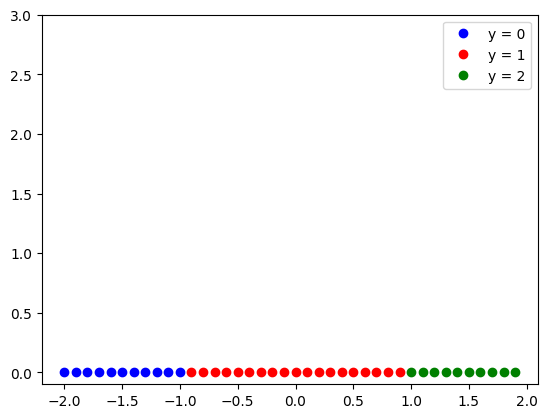

In [7]:
# Create the dataset object and plot the dataset object

data_set = Data()
data_set.x
plot_data(data_set)

In [8]:
# Build Softmax Classifier technically you only need nn.Linear

model = nn.Sequential(nn.Linear(1, 3))
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0075],
                      [ 0.5364],
                      [-0.8230]])),
             ('0.bias', tensor([-0.7359, -0.3852,  0.2682]))])

In [12]:
# Create criterion function, optimizer, and dataloader

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
trainloader = DataLoader(dataset = data_set, batch_size = 5)

# Train the model

LOSS = []
def train_model(epochs):
    for epoch in range(epochs):
        if epoch % 50 == 0:
            pass
            plot_data(data_set, model)
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            LOSS.append(loss)
            loss.backward()
            optimizer.step()

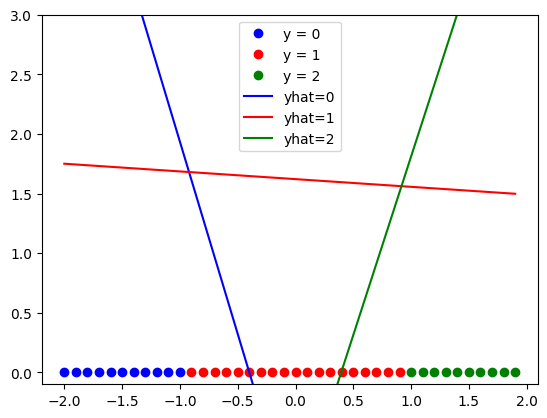

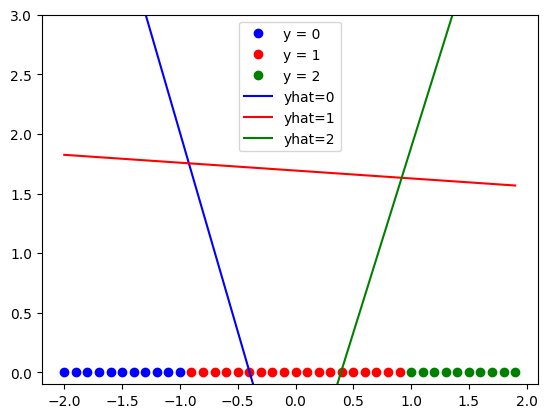

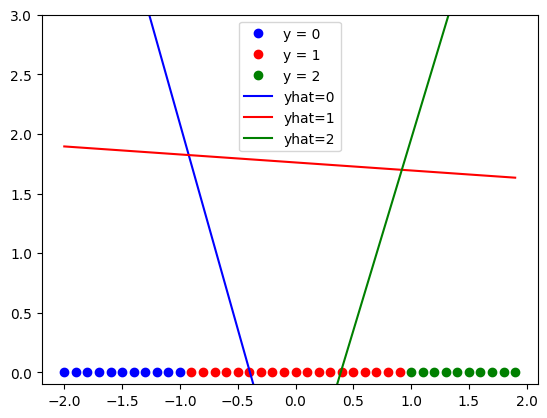

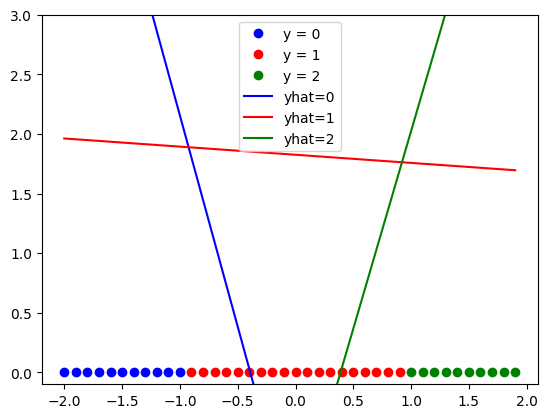

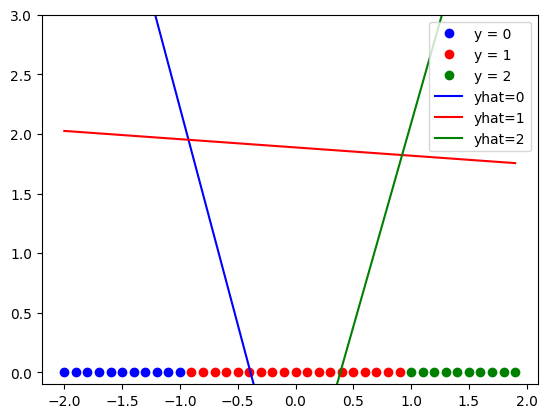

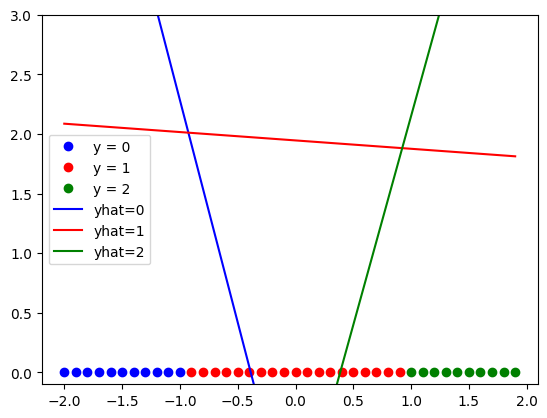

In [13]:
train_model(300)

In [14]:
# Make the prediction

z =  model(data_set.x)
_, yhat = z.max(1)
print("The prediction:", yhat)

The prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [15]:
# Print the accuracy

correct = (data_set.y == yhat).sum().item()
accuracy = correct / len(data_set)
print("The accuracy: ", accuracy)

The accuracy:  1.0


In [16]:
Softmax_fn=nn.Softmax(dim=-1)

In [17]:
Probability =Softmax_fn(z)

In [18]:
for i in range(3):
    print("probability of class {} isg given by  {}".format(i, Probability[0,i]) )

probability of class 0 isg given by  0.9823248386383057
probability of class 1 isg given by  0.01767483353614807
probability of class 2 isg given by  3.932175616228051e-07


---